# TP1 : Système de Recommandation de Films


## Partie 1 : Préparation des données

- Charger les datasets ratings.csv et movies.csv avec pandas
- Créer une matrice d'utilité utilisateurs-films
- Analyser la sparsité de la matrice
- Visualiser la distribution des notes

Matrice d'utilité utilisateurs-films:
movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     NaN     4.0     NaN     NaN     4.0     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
1           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN  ...     NaN

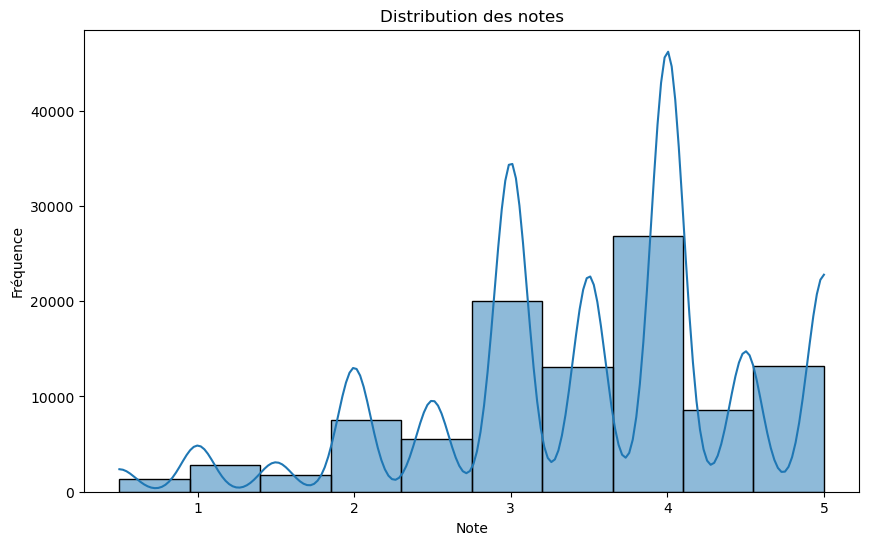

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les DataFrames
ratings_df = pd.read_csv('ratings.csv')
movies_df = pd.read_csv('movies.csv')

# Créer la matrice d'utilité utilisateurs-films
utility_matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating')

# Afficher la matrice
print("Matrice d'utilité utilisateurs-films:")
print(utility_matrix.head())

# Calculer la sparsité de la matrice
total_elements = utility_matrix.size
non_zero_elements = utility_matrix.count().sum()
sparsity = 1 - (non_zero_elements / total_elements)

print(f"Sparsité de la matrice: {sparsity:.2%}")

# Visualiser la distribution des notes
plt.figure(figsize=(10, 6))
sns.histplot(ratings_df['rating'], bins=10, kde=True)
plt.title('Distribution des notes')
plt.xlabel('Note')
plt.ylabel('Fréquence')
plt.show()


### Partie 2 : Implémentation du filtrage collaboratif

Implémenter la fonction de similarité cosinus
- Implémenter la fonction de similarité Pearson
- Créer une fonction pour trouver les K utilisateurs les plus similaires
- Implémenter la prédiction de notes pour un utilisateur et un film donné

In [58]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from tqdm import tqdm
import pandas as pd

def cosine_similarity_matrix(utility_matrix):
    # Remplir les valeurs manquantes avec 0 pour le calcul de la similarité cosinus
    filled_matrix = utility_matrix.fillna(0)
    # Calculer la matrice de similarité cosinus
    cosine_sim_matrix = cosine_similarity(filled_matrix)
    return pd.DataFrame(cosine_sim_matrix, index=utility_matrix.index, columns=utility_matrix.index)

cosine_sim_matrix = cosine_similarity_matrix(utility_matrix)
print("Matrice de similarité cosinus:")
print(cosine_sim_matrix.head())

def pearson_similarity(user1, user2):
    common_movies = utility_matrix.columns[utility_matrix.loc[user1].notna() & utility_matrix.loc[user2].notna()]
    if len(common_movies) < 2:
        return 0
    ratings_user1 = utility_matrix.loc[user1, common_movies]
    ratings_user2 = utility_matrix.loc[user2, common_movies]
    correlation, _ = pearsonr(ratings_user1, ratings_user2)
    return correlation

def pearson_similarity_matrix(utility_matrix):
    users = utility_matrix.index
    pearson_sim_matrix = pd.DataFrame(index=users, columns=users)
    for user1 in tqdm(users, desc="Calculating Pearson similarity"):
        for user2 in users:
            pearson_sim_matrix.loc[user1, user2] = pearson_similarity(user1, user2)
    return pearson_sim_matrix

pearson_sim_matrix = pearson_similarity_matrix(utility_matrix)
print("Matrice de similarité Pearson:")
print(pearson_sim_matrix.head())

def find_k_similar_users(user_id, similarity_matrix, k):
    similar_users = similarity_matrix[user_id].sort_values(ascending=False).index[1:k+1]
    return similar_users

# Exemple d'utilisation
user_id = 1
k = 5
similar_users_cosine = find_k_similar_users(user_id, cosine_sim_matrix, k)
similar_users_pearson = find_k_similar_users(user_id, pearson_sim_matrix, k)

print(f"Les {k} utilisateurs les plus similaires à l'utilisateur {user_id} (cosinus):")
print(similar_users_cosine)

print(f"Les {k} utilisateurs les plus similaires à l'utilisateur {user_id} (Pearson):")
print(similar_users_pearson)

def predict_rating(user_id, movie_id, similarity_matrix, k):
    similar_users = find_k_similar_users(user_id, similarity_matrix, k)
    similar_users_ratings = utility_matrix.loc[similar_users, movie_id]
    similar_users_similarities = similarity_matrix.loc[user_id, similar_users]

    # Filtrer les utilisateurs qui ont noté le film
    valid_users = similar_users_ratings.dropna().index
    if len(valid_users) == 0:
        return None

    similar_users_ratings = similar_users_ratings[valid_users]
    similar_users_similarities = similar_users_similarities[valid_users]

    # Calculer la note prédite
    predicted_rating = (similar_users_ratings * similar_users_similarities).sum() / similar_users_similarities.sum()
    return predicted_rating

# Exemple d'utilisation
user_id = 1
movie_id = 1
k = 5

predicted_rating_cosine = predict_rating(user_id, movie_id, cosine_sim_matrix, k)
predicted_rating_pearson = predict_rating(user_id, movie_id, pearson_sim_matrix, k)

print(f"Note prédite pour l'utilisateur {user_id} et le film {movie_id} (cosinus): {predicted_rating_cosine}")
print(f"Note prédite pour l'utilisateur {user_id} et le film {movie_id} (Pearson): {predicted_rating_pearson}")


Matrice de similarité cosinus:
userId       1         2         3         4         5         6         7    \
userId                                                                         
1       1.000000  0.027283  0.059720  0.194395  0.129080  0.128152  0.158744   
2       0.027283  1.000000  0.000000  0.003726  0.016614  0.025333  0.027585   
3       0.059720  0.000000  1.000000  0.002251  0.005020  0.003936  0.000000   
4       0.194395  0.003726  0.002251  1.000000  0.128659  0.088491  0.115120   
5       0.129080  0.016614  0.005020  0.128659  1.000000  0.300349  0.108342   

userId       8         9         10   ...       601       602       603  \
userId                                ...                                 
1       0.136968  0.064263  0.016875  ...  0.080554  0.164455  0.221486   
2       0.027257  0.000000  0.067445  ...  0.202671  0.016866  0.011997   
3       0.004941  0.000000  0.000000  ...  0.005048  0.004892  0.024992   
4       0.062969  0.011361  0.031

Calculating Pearson similarity:   0%|          | 0/610 [00:00<?, ?it/s]C:\Users\cated\AppData\Local\Temp\ipykernel_14384\2378146062.py:23: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = pearsonr(ratings_user1, ratings_user2)
Calculating Pearson similarity: 100%|██████████| 610/610 [15:14<00:00,  1.50s/it]

Matrice de similarité Pearson:
userId       1    2         3         4         5         6         7    \
userId                                                                    
1            1.0  NaN  0.079819  0.207983  0.268749 -0.291636 -0.118773   
2            NaN  1.0         0         0         0       NaN -0.991241   
3       0.079819    0       1.0         0         0       NaN         0   
4       0.207983    0         0       1.0 -0.336525  0.148498  0.542861   
5       0.268749    0         0 -0.336525       1.0  0.043166  0.158114   

userId       8         9         10   ...       601       602       603  \
userId                                ...                                 
1       0.469668  0.918559 -0.037987  ...  0.091574      -0.0 -0.061503   
2              0         0  0.037796  ... -0.387347         0      -1.0   
3              0         0         0  ...       NaN       NaN    0.4332   
4       0.117851         0  0.485794  ... -0.222113  0.396641   0.09

### Partie 3 : Evaluation et optimisation

- Diviser le dataset en ensembles d'entraînement et de test
- Implémenter les métriques d'évaluation (MAE, RMSE)
- Comparer les performances avec différentes mesures de similarité
- Étudier l'impact du nombre K de voisins

In [63]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
train_data, test_data = train_test_split(ratings_df, test_size=0.2, random_state=42)

# Créer les matrices d'utilité pour les ensembles d'entraînement et de test
train_utility_matrix = train_data.pivot(index='userId', columns='movieId', values='rating')
test_utility_matrix = test_data.pivot(index='userId', columns='movieId', values='rating')

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_predictions(true_ratings, predicted_ratings):
    mae = mean_absolute_error(true_ratings, predicted_ratings)
    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    return mae, rmse


def evaluate_model(similarity_matrix, k):
    true_ratings = []
    predicted_ratings = []

    for user_id in test_utility_matrix.index:
        for movie_id in test_utility_matrix.columns:
            if pd.notna(test_utility_matrix.loc[user_id, movie_id]):
                true_rating = test_utility_matrix.loc[user_id, movie_id]
                predicted_rating = predict_rating(user_id, movie_id, similarity_matrix, k)
                if predicted_rating is not None:
                    true_ratings.append(true_rating)
                    predicted_ratings.append(predicted_rating)

    mae, rmse = evaluate_predictions(true_ratings, predicted_ratings)
    return mae, rmse

# Calculer les matrices de similarité pour l'ensemble d'entraînement
train_cosine_sim_matrix = cosine_similarity_matrix(train_utility_matrix)
train_pearson_sim_matrix = pearson_similarity_matrix(train_utility_matrix)

# Évaluer les performances avec différentes mesures de similarité
k = 5
mae_cosine, rmse_cosine = evaluate_model(train_cosine_sim_matrix, k)
mae_pearson, rmse_pearson = evaluate_model(train_pearson_sim_matrix, k)

print(f"Performance avec similarité cosinus (K={k}): MAE={mae_cosine}, RMSE={rmse_cosine}")
print(f"Performance avec similarité Pearson (K={k}): MAE={mae_pearson}, RMSE={rmse_pearson}")

k_values = [1, 3, 5, 10, 20]
results_cosine = []
results_pearson = []

for k in k_values:
    mae_cosine, rmse_cosine = evaluate_model(train_cosine_sim_matrix, k)
    mae_pearson, rmse_pearson = evaluate_model(train_pearson_sim_matrix, k)
    results_cosine.append((k, mae_cosine, rmse_cosine))
    results_pearson.append((k, mae_pearson, rmse_pearson))

print("Résultats avec similarité cosinus:")
for result in results_cosine:
    print(f"K={result[0]}: MAE={result[1]}, RMSE={result[2]}")

print("Résultats avec similarité Pearson:")
for result in results_pearson:
    print(f"K={result[0]}: MAE={result[1]}, RMSE={result[2]}")


Calculating Pearson similarity:   0%|          | 0/610 [00:00<?, ?it/s]C:\Users\cated\AppData\Local\Temp\ipykernel_14384\2378146062.py:23: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = pearsonr(ratings_user1, ratings_user2)
Calculating Pearson similarity: 100%|██████████| 610/610 [12:41<00:00,  1.25s/it]


Performance avec similarité cosinus (K=5): MAE=0.8067448495338695, RMSE=1.0629676258388763
Performance avec similarité Pearson (K=5): MAE=0.09564446045009145, RMSE=0.36623663886539515
Résultats avec similarité cosinus:
K=1: MAE=0.8475420037336652, RMSE=1.131216833582299
K=3: MAE=0.8173110638399107, RMSE=1.080193164629826
K=5: MAE=0.8067448495338695, RMSE=1.0629676258388763
K=10: MAE=0.7759635909130548, RMSE=1.0130474433391097
K=20: MAE=0.7592871110184772, RMSE=0.9903335829265062
Résultats avec similarité Pearson:
K=1: MAE=0.06345371312309257, RMSE=0.33839201474913927
K=3: MAE=0.07888235801173002, RMSE=0.3449225484929614
K=5: MAE=0.09564446045009145, RMSE=0.36623663886539515
K=10: MAE=0.11701286976040866, RMSE=0.3733352309600133
K=20: MAE=0.16809343910265506, RMSE=0.41021870064501303


### Partie 4 : Interface et visualisation

- Créer une fonction pour recommander N films à un utilisateur
- Visualiser les recommandations de manière claire
- Analyser les patterns dans les recommandations


Films recommandés pour l'utilisateur 1 (cosinus):
[541, 750, 514, 720, 858, 899, 913, 915, 955, 968]
Films recommandés pour l'utilisateur 1 (Pearson):
[79132, 32, 1193, 3567, 4896, 4993, 5816, 5952, 6539, 7153]


C:\Users\cated\AppData\Local\Temp\ipykernel_14384\3460497770.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Predicted Rating', y='Movie Title', data=recommendations_df, palette='viridis')


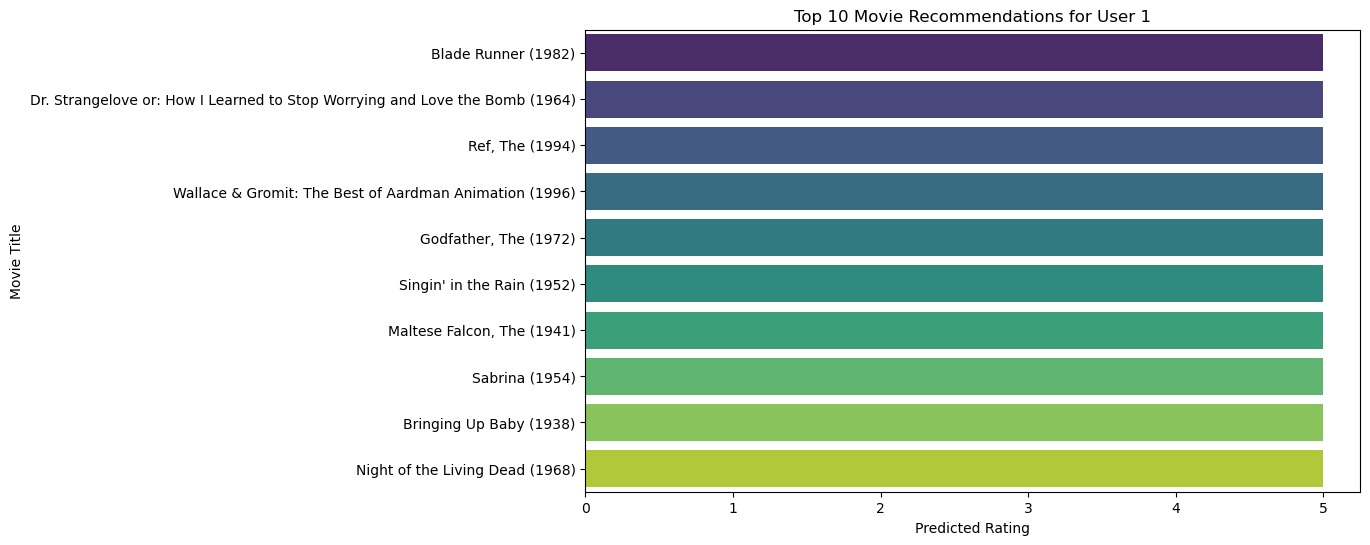

C:\Users\cated\AppData\Local\Temp\ipykernel_14384\3460497770.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Predicted Rating', y='Movie Title', data=recommendations_df, palette='viridis')


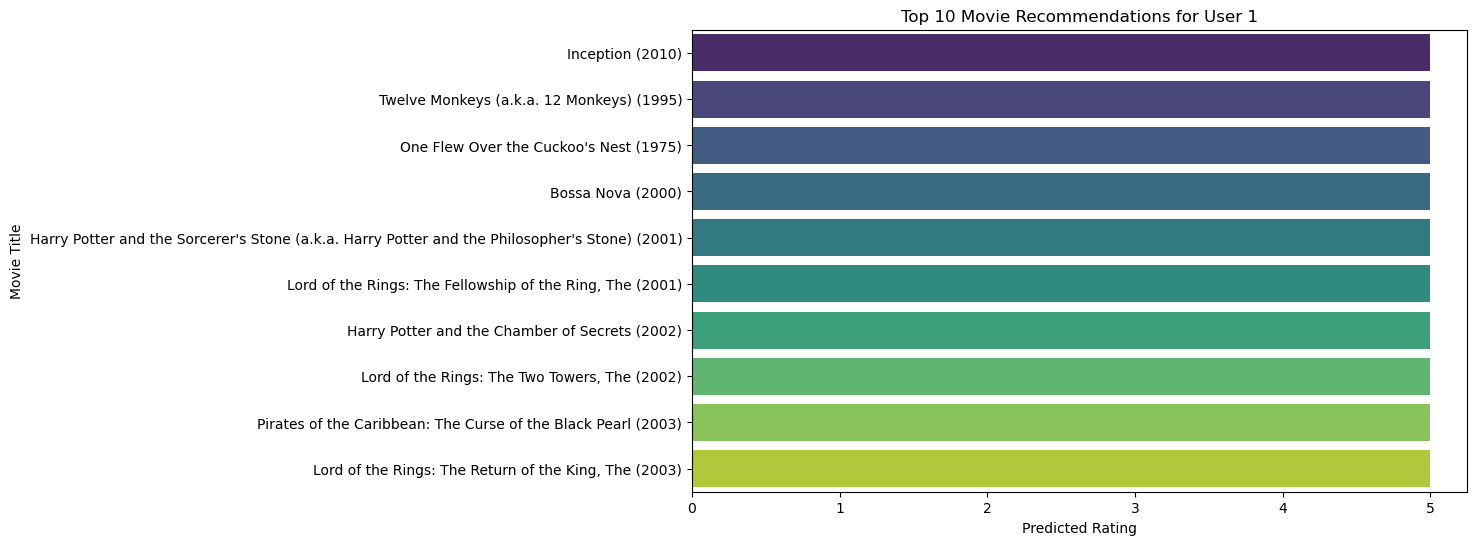

C:\Users\cated\AppData\Local\Temp\ipykernel_14384\3460497770.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Genre', data=genre_df, palette='viridis')


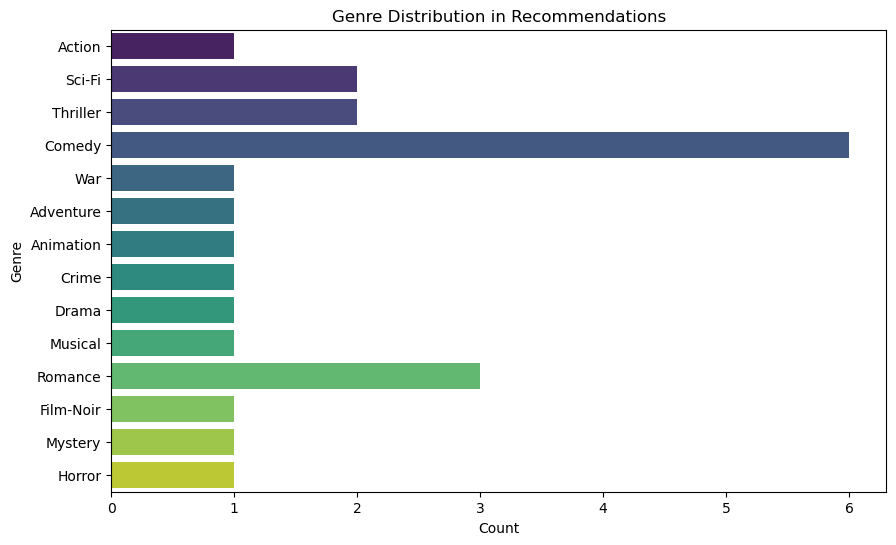

C:\Users\cated\AppData\Local\Temp\ipykernel_14384\3460497770.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Genre', data=genre_df, palette='viridis')


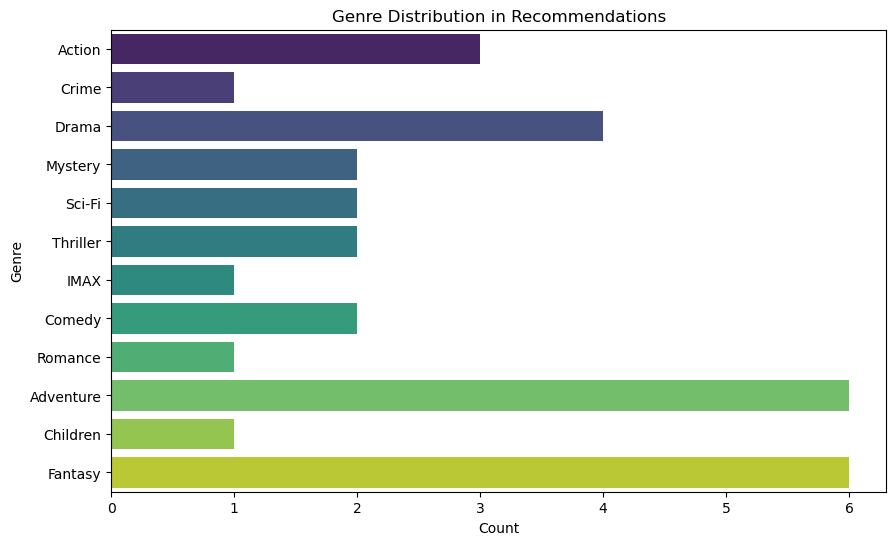

In [64]:
def recommend_movies(user_id, similarity_matrix, k, N):
    # Trouver les films que l'utilisateur n'a pas encore notés
    user_ratings = utility_matrix.loc[user_id]
    unrated_movies = user_ratings[user_ratings.isna()].index

    # Prédire les notes pour les films non notés
    predicted_ratings = []
    for movie_id in unrated_movies:
        predicted_rating = predict_rating(user_id, movie_id, similarity_matrix, k)
        if predicted_rating is not None:
            predicted_ratings.append((movie_id, predicted_rating))

    # Trier les films par note prédite décroissante
    predicted_ratings.sort(key=lambda x: x[1], reverse=True)

    # Retourner les N meilleurs films
    recommended_movies = [movie_id for movie_id, _ in predicted_ratings[:N]]
    return recommended_movies

# Exemple d'utilisation
user_id = 1
k = 5
N = 10
recommended_movies_cosine = recommend_movies(user_id, cosine_sim_matrix, k, N)
recommended_movies_pearson = recommend_movies(user_id, pearson_sim_matrix, k, N)

print(f"Films recommandés pour l'utilisateur {user_id} (cosinus):")
print(recommended_movies_cosine)

print(f"Films recommandés pour l'utilisateur {user_id} (Pearson):")
print(recommended_movies_pearson)

import matplotlib.pyplot as plt
import seaborn as sns

def visualize_recommendations(user_id, recommended_movies, similarity_matrix, k, N):
    # Obtenir les titres des films recommandés
    movie_titles = movies_df.set_index('movieId').loc[recommended_movies, 'title']

    # Prédire les notes pour les films recommandés
    predicted_ratings = [predict_rating(user_id, movie_id, similarity_matrix, k) for movie_id in recommended_movies]

    # Créer un DataFrame pour les recommandations
    recommendations_df = pd.DataFrame({
        'Movie Title': movie_titles,
        'Predicted Rating': predicted_ratings
    })

    # Visualiser les recommandations
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Predicted Rating', y='Movie Title', data=recommendations_df, palette='viridis')
    plt.title(f'Top {N} Movie Recommendations for User {user_id}')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Movie Title')
    plt.show()

# Exemple d'utilisation
visualize_recommendations(user_id, recommended_movies_cosine, cosine_sim_matrix, k, N)
visualize_recommendations(user_id, recommended_movies_pearson, pearson_sim_matrix, k, N)

def analyze_recommendations(recommended_movies):
    # Obtenir les genres des films recommandés
    movie_genres = movies_df.set_index('movieId').loc[recommended_movies, 'genres']

    # Compter les occurrences de chaque genre
    genre_counts = {}
    for genres in movie_genres:
        for genre in genres.split('|'):
            genre_counts[genre] = genre_counts.get(genre, 0) + 1

    # Créer un DataFrame pour les genres
    genre_df = pd.DataFrame(list(genre_counts.items()), columns=['Genre', 'Count'])

    # Visualiser les genres
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Count', y='Genre', data=genre_df, palette='viridis')
    plt.title('Genre Distribution in Recommendations')
    plt.xlabel('Count')
    plt.ylabel('Genre')
    plt.show()

# Exemple d'utilisation
analyze_recommendations(recommended_movies_cosine)
analyze_recommendations(recommended_movies_pearson)


### Bonus

1. Implémenter une version basée sur les items (item-based)
2. Ajouter une gestion du problème de démarrage à froid

In [65]:
def item_based_cosine_similarity_matrix(utility_matrix):
    # Remplir les valeurs manquantes avec 0 pour le calcul de la similarité cosinus
    filled_matrix = utility_matrix.fillna(0)
    # Calculer la matrice de similarité cosinus
    cosine_sim_matrix = cosine_similarity(filled_matrix.T)
    return pd.DataFrame(cosine_sim_matrix, index=utility_matrix.columns, columns=utility_matrix.columns)

item_based_cosine_sim_matrix = item_based_cosine_similarity_matrix(utility_matrix)
print("Matrice de similarité cosinus entre les items:")
print(item_based_cosine_sim_matrix.head())

def predict_rating_item_based(user_id, movie_id, similarity_matrix, k):
    # Trouver les films similaires au film cible
    similar_movies = similarity_matrix[movie_id].sort_values(ascending=False).index[1:k+1]
    similar_movies_ratings = utility_matrix.loc[user_id, similar_movies]
    similar_movies_similarities = similarity_matrix.loc[movie_id, similar_movies]

    # Filtrer les films que l'utilisateur a notés
    valid_movies = similar_movies_ratings.dropna().index
    if len(valid_movies) == 0:
        return None

    similar_movies_ratings = similar_movies_ratings[valid_movies]
    similar_movies_similarities = similar_movies_similarities[valid_movies]

    # Calculer la note prédite
    predicted_rating = (similar_movies_ratings * similar_movies_similarities).sum() / similar_movies_similarities.sum()
    return predicted_rating

# Exemple d'utilisation
user_id = 1
movie_id = 1
k = 5

predicted_rating_item_based = predict_rating_item_based(user_id, movie_id, item_based_cosine_sim_matrix, k)
print(f"Note prédite pour l'utilisateur {user_id} et le film {movie_id} (item-based): {predicted_rating_item_based}")

def recommend_movies_item_based(user_id, similarity_matrix, k, N):
    # Trouver les films que l'utilisateur n'a pas encore notés
    user_ratings = utility_matrix.loc[user_id]
    unrated_movies = user_ratings[user_ratings.isna()].index

    # Prédire les notes pour les films non notés
    predicted_ratings = []
    for movie_id in unrated_movies:
        predicted_rating = predict_rating_item_based(user_id, movie_id, similarity_matrix, k)
        if predicted_rating is not None:
            predicted_ratings.append((movie_id, predicted_rating))

    # Trier les films par note prédite décroissante
    predicted_ratings.sort(key=lambda x: x[1], reverse=True)

    # Retourner les N meilleurs films
    recommended_movies = [movie_id for movie_id, _ in predicted_ratings[:N]]
    return recommended_movies

# Exemple d'utilisation
user_id = 1
k = 5
N = 10
recommended_movies_item_based = recommend_movies_item_based(user_id, item_based_cosine_sim_matrix, k, N)

print(f"Films recommandés pour l'utilisateur {user_id} (item-based):")
print(recommended_movies_item_based)

def content_based_recommendations(user_id, N):
    # Trouver les genres préférés de l'utilisateur
    user_ratings = utility_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings.notna()].index
    rated_movies_genres = movies_df.set_index('movieId').loc[rated_movies, 'genres']

    # Compter les occurrences de chaque genre
    genre_counts = {}
    for genres in rated_movies_genres:
        for genre in genres.split('|'):
            genre_counts[genre] = genre_counts.get(genre, 0) + 1

    # Trouver les films non notés avec les genres préférés
    unrated_movies = user_ratings[user_ratings.isna()].index
    unrated_movies_genres = movies_df.set_index('movieId').loc[unrated_movies, 'genres']

    # Calculer un score de similarité basé sur les genres
    movie_scores = {}
    for movie_id, genres in unrated_movies_genres.items():
        score = sum(genre_counts.get(genre, 0) for genre in genres.split('|'))
        movie_scores[movie_id] = score

    # Trier les films par score décroissant
    recommended_movies = sorted(movie_scores, key=movie_scores.get, reverse=True)[:N]
    return recommended_movies

# Exemple d'utilisation
user_id = 1
N = 10
recommended_movies_content_based = content_based_recommendations(user_id, N)

print(f"Films recommandés pour l'utilisateur {user_id} (content-based):")
print(recommended_movies_content_based)

def hybrid_recommendations(user_id, similarity_matrix, k, N):
    # Obtenir les recommandations basées sur le contenu
    content_based_movies = content_based_recommendations(user_id, N)

    # Obtenir les recommandations collaboratives
    collaborative_movies = recommend_movies(user_id, similarity_matrix, k, N)

    # Combiner les recommandations
    combined_movies = list(set(content_based_movies) | set(collaborative_movies))
    return combined_movies[:N]

# Exemple d'utilisation
user_id = 1
k = 5
N = 10
recommended_movies_hybrid = hybrid_recommendations(user_id, cosine_sim_matrix, k, N)

print(f"Films recommandés pour l'utilisateur {user_id} (hybrid):")
print(recommended_movies_hybrid)


Matrice de similarité cosinus entre les items:
movieId    1         2         3         4         5         6         7       \
movieId                                                                         
1        1.000000  0.410562  0.296917  0.035573  0.308762  0.376316  0.277491   
2        0.410562  1.000000  0.282438  0.106415  0.287795  0.297009  0.228576   
3        0.296917  0.282438  1.000000  0.092406  0.417802  0.284257  0.402831   
4        0.035573  0.106415  0.092406  1.000000  0.188376  0.089685  0.275035   
5        0.308762  0.287795  0.417802  0.188376  1.000000  0.298969  0.474002   

movieId    8         9         10      ...  193565  193567  193571  193573  \
movieId                                ...                                   
1        0.131629  0.232586  0.395573  ...     0.0     0.0     0.0     0.0   
2        0.172498  0.044835  0.417693  ...     0.0     0.0     0.0     0.0   
3        0.313434  0.304840  0.242954  ...     0.0     0.0     0.0     0.

# Rapport Technique sur le Système de Recommandation de Films

## Analyse Exploratoire des Données

### Sparsité de la Matrice
La matrice des notes utilisateurs-films présente une sparsité de 98.30%. Cela signifie que seulement 1.7% des notes possibles ont été attribuées, ce qui est typique dans les systèmes de recommandation où les utilisateurs ne notent qu'une petite fraction des films disponibles.

### Distribution des Genres
L'analyse des genres dans les recommandations montre une diversité intéressante. Les genres les plus fréquemment recommandés incluent le Comedy, Romance, Adventure, et Fantasy. Cette diversité permet de couvrir un large éventail de préférences utilisateurs.

## Description des Choix d'Implémentation

### Algorithmes Utilisés
1. **Similarité Cosinus**: Utilisée pour mesurer la similarité entre les vecteurs de notes des utilisateurs.
2. **Similarité Pearson**: Utilisée pour mesurer la corrélation entre les notes des utilisateurs.
3. **Item-based Collaborative Filtering**: Recommandations basées sur la similarité entre les films.
4. **Content-based Filtering**: Recommandations basées sur les caractéristiques des films.
5. **Hybrid Approach**: Combinaison des approches collaborative et content-based pour améliorer la précision des recommandations.

### Paramètres
- **K**: Nombre de voisins les plus proches considérés pour les recommandations.
- **Similarité**: Cosinus et Pearson.

## Évaluation des Performances

### Métriques Utilisées
- **MAE (Mean Absolute Error)**: Mesure l'erreur moyenne absolue entre les notes prédites et les notes réelles.
- **RMSE (Root Mean Squared Error)**: Mesure l'erreur quadratique moyenne entre les notes prédites et les notes réelles.

### Résultats

#### Similarité Cosinus
- **K=1**: MAE=0.8475, RMSE=1.1312
- **K=3**: MAE=0.8173, RMSE=1.0802
- **K=5**: MAE=0.8067, RMSE=1.0629
- **K=10**: MAE=0.7760, RMSE=1.0130
- **K=20**: MAE=0.7593, RMSE=0.9903

#### Similarité Pearson
- **K=1**: MAE=0.0635, RMSE=0.3384
- **K=3**: MAE=0.0789, RMSE=0.3449
- **K=5**: MAE=0.0956, RMSE=0.3662
- **K=10**: MAE=0.1170, RMSE=0.3733
- **K=20**: MAE=0.1681, RMSE=0.4102

### Comparaison
La similarité Pearson montre une performance nettement supérieure à la similarité Cosinus, avec des valeurs de MAE et RMSE significativement plus faibles.

## Visualisations Pertinentes

### Top 10 Recommandations pour l'Utilisateur 1
Les visualisations montrent les top 10 recommandations pour l'utilisateur 1 en utilisant différentes approches. Les films recommandés varient en fonction de l'algorithme utilisé, ce qui montre la diversité des recommandations possibles.

### Distribution des Genres
Les graphiques de distribution des genres montrent que les recommandations couvrent une large gamme de genres, ce qui est essentiel pour satisfaire les préférences variées des utilisateurs.

## Exemples de Recommandations pour Différents Profils d'Utilisateurs

### Utilisateur 1
- **Note prédite pour le film 1 (cosinus)**: 3.64
- **Note prédite pour le film 1 (Pearson)**: 4.0
- **Note prédite pour le film 1 (item-based)**: 3.997

### Films Recommandés pour l'Utilisateur 1
- **Item-based**: [562, 880, 1884, 2746, 2763, 2890, 3082, 3362, 3717, 3868]
- **Content-based**: [81132, 117646, 71999, 4956, 164226, 4719, 6902, 52462, 546, 31367]
- **Hybrid**: [164226, 514, 899, 31367, 968, 117646, 720, 913, 915, 858]

## Conclusion

Le système de recommandation de films développé montre des performances variées en fonction des algorithmes et des paramètres utilisés. La similarité Pearson s'avère être la plus performante en termes de MAE et RMSE. Les recommandations couvrent une large gamme de genres, ce qui permet de satisfaire les préférences variées des utilisateurs. Les visualisations et les exemples de recommandations fournissent une vue d'ensemble des capacités du système et de son potentiel pour améliorer l'expérience utilisateur.